In [26]:
from pyzx.rules import*
import pyzx as zx
import random
from pyzx.graph.base import BaseGraph, VT, ET
from typing import List, Callable, Optional, Union, Generic, Tuple, Dict, Iterator, cast
from typing import TypeVar
from copy import deepcopy
import numpy as np

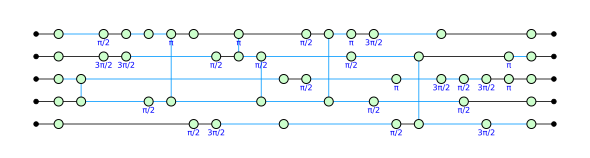

In [100]:
# Rewrite_match と同じ回路なので比較してみましょう。
qubit = 5
depth = 20
random.seed(50)
circ = zx.generate.cliffords(qubit, depth)
zx.simplify.to_gh(circ)
zx.draw_matplotlib(circ)

In [101]:
MatchObject = TypeVar("MatchObject")
RewriteOutputType = Tuple[Dict[Tuple[VT,VT],List[int]], List[VT], List[ET], bool]

## Clifford Simp
Clifford_match_functions = [match_ids_parallel, match_spider_parallel, match_pivot_parallel, match_lcomp_parallel]
Clifford_rewrite_functions = [remove_ids, spider, pivot, lcomp]

In [102]:
def search_all_simp_match(
    g:BaseGraph[VT, ET],
    match_funcions: List[Callable[..., List[MatchObject]]],
) -> Dict[str, List[MatchObject]]:
    all_results = {}
    # Execute match-search methods and store them
    for match_func in match_funcions:
        results = match_func(g)
        all_results[match_func.__name__] = results
    
    # for name, result in all_results.items():
        # print(f"Results for {name}: {result}")
    
    return all_results

多分、幅優先探索的になると思われます。

In [179]:
def apply_simp(
    g:BaseGraph[VT, ET],
    rewrite_function:Callable[..., List[MatchObject]],
    match:List[MatchObject],
):
    g1 = deepcopy(g)
    etab, rem_verts, rem_edges, check_isolated_vertices = \
    rewrite_function(g,match)
    g1.add_edge_table(etab)
    g1.remove_edges(rem_edges)
    g1.remove_vertices(rem_verts)
    if check_isolated_vertices: g1.remove_isolated_vertices()
    return g1

class ActionNode:
    def __init__(self,  
    rewrited_graph, applied_match = None, applied_rewrite = None) -> None:
        self.graph = rewrited_graph
        self.applied_match = applied_match
        self.applied_rewrite = applied_rewrite
        self.children = []
    
    def add_childnode(self, childnode):
        self.children.append(childnode)
    
    """def __repr__(self):
        pass"""

class ActionTree:
    def __init__(self, initial_graph) -> None:
        self.root = ActionNode(initial_graph)
        self.current_node = self.root
    
    def add_action_matches(self, 
        match_functions,
        rewrite_functions,
        node = None):    # current_node, または、指定のノードについて、childnode を作る
        if node is None: node = self.current_node
        
        match_results = search_all_simp_match(node.graph, match_functions)
        if all(not value for value in match_results.values()): # すべてのmatch が空の場合に、ぬける
            return
        
        i = 0
        for key, matches in match_results.items():
            for j in range(len(matches)):
                g1 = deepcopy(node.graph)
                g2 = apply_simp(g1, rewrite_functions[i], [matches[j]])
                new_node = ActionNode(g2, [matches[j]], rewrite_functions[i])
                node.add_childnode(new_node)
            i += 1
    
    def show(self, node = None, level = 0):
        if node is None:
            node = self.root
        if node.applied_rewrite == None or node.applied_match == None:
            print("  " * level + f"Applied Rewrite: {node.applied_rewrite}, Applied Match: {node.applied_match}, Graph : {node.graph.__class__}")
        else:
            print("  " * level + f"Applied Rewrite: {node.applied_rewrite.__name__}, Applied Match: {node.applied_match}, Graph : {node.graph.__class__}")
        for child in node.children:
            self.show(child, level+1)

In [188]:
dict = {"i":[], "j":[]}
if all(not value for value in dict.values()):
    print("empty")

empty


In [180]:
action_tree = ActionTree(circ)
action_tree.show()

Applied Rewrite: None, Applied Match: None, Graph : <class 'pyzx.graph.graph_s.GraphS'>


In [182]:
action_tree.add_action_matches(Clifford_match_functions, Clifford_rewrite_functions)
print(action_tree.current_node.graph)
print(action_tree.current_node.children[0])
print(action_tree.current_node.children[0].graph)
print(action_tree.current_node.children[0].children)

Graph(60 vertices, 61 edges)
Graph(59 vertices, 60 edges)
[]


In [183]:
match_results = search_all_simp_match(action_tree.current_node.children[0].graph, Clifford_match_functions)
print(match_results.items())

dict_items([('match_ids_parallel', [(6, 1, 12, 1), (7, 2, 11, 2), (8, 3, 10, 1), (9, 4, 20, 1), (15, 13, 16, 2), (21, 19, 25, 1), (28, 11, 30, 2), (29, 22, 38, 1), (42, 50, 36, 2), (51, 49, 56, 2), (52, 48, 57, 1), (53, 44, 58, 1), (54, 47, 59, 2)]), ('match_spider_parallel', [(6, 12), (41, 49), (35, 36), (21, 25), (46, 48), (28, 30), (9, 20), (44, 53), (8, 10), (13, 15)]), ('match_pivot_parallel', [(27, 33, [], []), (7, 11, [2], [])]), ('match_lcomp_parallel', [(17, [10, 18]), (26, [27, 24, 34]), (37, [44, 33]), (43, [39, 45]), (47, [40, 54])])])


In [184]:
action_tree.add_action_matches(Clifford_match_functions, Clifford_rewrite_functions, \
                            node=action_tree.current_node.children[0])
print(action_tree.current_node.children[0].children)

[<__main__.ActionNode object at 0x000001D929C0E340>, <__main__.ActionNode object at 0x000001D929C0ECA0>, <__main__.ActionNode object at 0x000001D929C0E430>, <__main__.ActionNode object at 0x000001D929AEF1F0>, <__main__.ActionNode object at 0x000001D928507B50>, <__main__.ActionNode object at 0x000001D929E82B80>, <__main__.ActionNode object at 0x000001D929CAF610>, <__main__.ActionNode object at 0x000001D929A2E2B0>, <__main__.ActionNode object at 0x000001D9280E9CD0>, <__main__.ActionNode object at 0x000001D929CAF760>, <__main__.ActionNode object at 0x000001D9296AE1C0>, <__main__.ActionNode object at 0x000001D9298C7A00>, <__main__.ActionNode object at 0x000001D929C28340>, <__main__.ActionNode object at 0x000001D92835DB20>, <__main__.ActionNode object at 0x000001D929E82A00>, <__main__.ActionNode object at 0x000001D927EE03A0>, <__main__.ActionNode object at 0x000001D929CAF9A0>, <__main__.ActionNode object at 0x000001D929CAFA90>, <__main__.ActionNode object at 0x000001D929CAFB20>, <__main__.A

In [189]:
# 深さ優先探索的な
action_tree = ActionTree(circ)
action_tree.add_action_matches(Clifford_match_functions, Clifford_rewrite_functions)
while action_tree.current_node.children:
    action_tree.current_node = action_tree.current_node.children[0]
    action_tree.add_action_matches(Clifford_match_functions, Clifford_rewrite_functions)
action_tree.show()

Applied Rewrite: None, Applied Match: None, Graph : <class 'pyzx.graph.graph_s.GraphS'>
  Applied Rewrite: remove_ids, Applied Match: [(5, 0, 13, 2)], Graph : <class 'pyzx.graph.graph_s.GraphS'>
    Applied Rewrite: remove_ids, Applied Match: [(6, 1, 12, 1)], Graph : <class 'pyzx.graph.graph_s.GraphS'>
      Applied Rewrite: remove_ids, Applied Match: [(7, 2, 11, 2)], Graph : <class 'pyzx.graph.graph_s.GraphS'>
        Applied Rewrite: remove_ids, Applied Match: [(8, 3, 10, 1)], Graph : <class 'pyzx.graph.graph_s.GraphS'>
          Applied Rewrite: remove_ids, Applied Match: [(9, 4, 20, 1)], Graph : <class 'pyzx.graph.graph_s.GraphS'>
            Applied Rewrite: remove_ids, Applied Match: [(15, 13, 16, 2)], Graph : <class 'pyzx.graph.graph_s.GraphS'>
              Applied Rewrite: remove_ids, Applied Match: [(16, 19, 13, 1)], Graph : <class 'pyzx.graph.graph_s.GraphS'>
                Applied Rewrite: remove_ids, Applied Match: [(21, 19, 25, 1)], Graph : <class 'pyzx.graph.graph_s.Gra

In [163]:
def brute_force_search(
    g:BaseGraph[VT, ET],
    match_functions: List[Callable[..., List[MatchObject]]],
    rewrite_functions: List[Callable[[BaseGraph[VT, ET], List[MatchObject]], RewriteOutputType[VT, ET]]],
):
    action_tree = ActionTree(circ)
    action_tree.add_action_matches(Clifford_match_functions, Clifford_rewrite_functions)
    # current node の child node の child node の生成
    for i in range(len(action_tree.current_node.children)):
        action_tree.add_action_matches(Clifford_match_functions, Clifford_rewrite_functions, \
                                    node=action_tree.current_node.children[i])
    

In [75]:
def simp_forward(
    g:BaseGraph[VT, ET],
    rewrite_functions: List[Callable[[BaseGraph[VT, ET], List[MatchObject]], RewriteOutputType[VT, ET]]],
    match_results: Dict[str, List[MatchObject]],
):
    all_graph_results = {}
    i = 0
    for key, matches in match_results.items():
        print(f"Processing rewrite function: {rewrite_functions[i].__name__}")
        # 処理があっているかを確認しようと思ったけど、これじゃダメですねえ
        # if key != rewrite_functions[i].__name__: 
            # raise ValueError("Unexpected functions. Expected",key)
        
        all_graph_results[rewrite_functions[i].__name__] = []
        try:
            for j in range(len(matches)):
                g1 = deepcopy(g)
                print(f"Processing matches:{matches[j]}")
                g2 = apply_simp(g1, rewrite_functions[i], [matches[j]])
                all_graph_results[rewrite_functions[i].__name__].append(g2)
                ## print(g2.stats())
        except Exception as e:
            print(e)
        print(f"finish process :{rewrite_functions[i].__name__} \n")
        i += 1
    return all_graph_results

In [95]:
qubits = 5
depth = 20
random.seed(50)
diagram = zx.generate.cliffords(qubits, depth)
zx.simplify.to_gh(diagram)
print(diagram)
results = search_all_simp_match(diagram, Clifford_match_functions)
all_graph_results = simp_forward(diagram, Clifford_rewrite_functions, results)

Graph(60 vertices, 61 edges)
Processing rewrite function: remove_ids
Processing matches:(5, 0, 13, 2)
Processing matches:(6, 1, 12, 1)
Processing matches:(7, 2, 11, 2)
Processing matches:(8, 3, 10, 1)
Processing matches:(9, 4, 20, 1)
Processing matches:(15, 13, 16, 2)
Processing matches:(21, 19, 25, 1)
Processing matches:(28, 11, 30, 2)
Processing matches:(29, 22, 38, 1)
Processing matches:(42, 50, 36, 2)
Processing matches:(51, 49, 56, 2)
Processing matches:(52, 48, 57, 1)
Processing matches:(53, 44, 58, 1)
Processing matches:(54, 47, 59, 2)
finish process :remove_ids 

Processing rewrite function: spider
Processing matches:(6, 12)
Processing matches:(41, 49)
Processing matches:(35, 36)
Processing matches:(21, 25)
Processing matches:(46, 48)
Processing matches:(28, 30)
Processing matches:(9, 20)
Processing matches:(44, 53)
Processing matches:(8, 10)
Processing matches:(13, 15)
finish process :spider 

Processing rewrite function: pivot
Processing matches:(27, 33, [], [])
Processing ma

In [96]:
print(all_graph_results)
print("number of ids match :", len(results[Clifford_match_functions[0].__name__]))
print("number of rewrited diagrams with ids:",len(all_graph_results[Clifford_rewrite_functions[0].__name__]))

{'remove_ids': [Graph(59 vertices, 60 edges), Graph(59 vertices, 60 edges), Graph(59 vertices, 60 edges), Graph(59 vertices, 60 edges), Graph(59 vertices, 60 edges), Graph(59 vertices, 60 edges), Graph(59 vertices, 60 edges), Graph(59 vertices, 60 edges), Graph(59 vertices, 60 edges), Graph(59 vertices, 60 edges), Graph(59 vertices, 60 edges), Graph(59 vertices, 60 edges), Graph(59 vertices, 60 edges), Graph(59 vertices, 60 edges)], 'spider': [Graph(59 vertices, 60 edges), Graph(59 vertices, 60 edges), Graph(59 vertices, 60 edges), Graph(59 vertices, 60 edges), Graph(59 vertices, 60 edges), Graph(59 vertices, 60 edges), Graph(59 vertices, 60 edges), Graph(59 vertices, 60 edges), Graph(59 vertices, 60 edges), Graph(59 vertices, 60 edges)], 'pivot': [Graph(58 vertices, 60 edges), Graph(59 vertices, 60 edges)], 'lcomp': [Graph(59 vertices, 60 edges), Graph(59 vertices, 61 edges), Graph(59 vertices, 60 edges), Graph(59 vertices, 60 edges), Graph(59 vertices, 60 edges)]}
number of ids match

In [93]:
num_results ={}
for key, graphs in all_graph_results.items():
    num_results.update({key:[]})
    for i in range(len(graphs)):
        results = search_all_simp_match(graphs[i], Clifford_match_functions)
        num_matches = 0
        for j in range(4):
            num_matches += len(results[Clifford_match_functions[j].__name__])
        num_results[key].append(num_matches)

print(num_results)

{'remove_ids': [30, 30, 29, 29, 30, 31, 30, 30, 30, 31, 30, 30, 29, 29], 'spider': [31, 32, 31, 30, 31, 30, 31, 29, 29, 31], 'pivot': [29, 29], 'lcomp': [30, 31, 30, 31, 30]}


In [97]:
# check whether number of matches and graphs are equal 
for i in range(4):
    a = len(results[Clifford_match_functions[i].__name__])
    b = len(all_graph_results[Clifford_rewrite_functions[i].__name__])
    if a == b: print("ok",a)
    else: print(i, "false")

ok 14
ok 10
ok 2
ok 5


In [98]:
# check all the rewrited graphs are different from each other
for i in range(len(all_graph_results[Clifford_rewrite_functions[0].__name__])):
    for j in range(len(all_graph_results[Clifford_rewrite_functions[0].__name__])):
        c1 = all_graph_results[Clifford_rewrite_functions[0].__name__][i]
        c2 = all_graph_results[Clifford_rewrite_functions[0].__name__][j]
        if i == j: continue
        if c1 == c2: print("False")

## Rewrite の目安回数の見積もり

In [29]:
dict = {}
for i in range(1000):
    random.seed(i)
    qubits = 5
    depth = 20
    diagram = zx.generate.cliffords(qubits, depth)
    zx.simplify.to_gh(diagram)
    results = search_all_simp_match(diagram, Clifford_match_functions)
    value1 = value2 = value3 = value4 = 0
    for key, items in results.items():
        num = len(items)
        # print(num)
        if key == Clifford_match_functions[0].__name__: value1 += num
        if key == Clifford_match_functions[1].__name__: value2 += num
        if key == Clifford_match_functions[2].__name__: value3 += num
        if key == Clifford_match_functions[3].__name__: value4 += num
    dict[i] = (value1, value2, value3, value4)

print(dict)

{0: (13, 11, 6, 5), 1: (15, 11, 1, 4), 2: (16, 10, 2, 6), 3: (13, 9, 2, 4), 4: (12, 9, 3, 0), 5: (17, 10, 2, 3), 6: (14, 11, 2, 3), 7: (16, 11, 3, 4), 8: (13, 11, 3, 1), 9: (11, 12, 3, 6), 10: (12, 11, 3, 4), 11: (12, 8, 7, 6), 12: (13, 9, 2, 5), 13: (13, 13, 0, 2), 14: (11, 12, 2, 4), 15: (13, 9, 2, 1), 16: (15, 9, 3, 2), 17: (15, 9, 1, 5), 18: (13, 11, 3, 3), 19: (13, 11, 2, 6), 20: (13, 11, 1, 3), 21: (15, 10, 4, 2), 22: (16, 10, 2, 4), 23: (11, 8, 4, 5), 24: (16, 11, 1, 4), 25: (15, 11, 1, 3), 26: (13, 13, 1, 3), 27: (11, 11, 5, 2), 28: (14, 11, 2, 2), 29: (11, 10, 1, 4), 30: (15, 10, 1, 2), 31: (15, 9, 1, 4), 32: (15, 9, 0, 4), 33: (14, 12, 1, 7), 34: (15, 10, 3, 3), 35: (13, 11, 1, 6), 36: (11, 11, 2, 1), 37: (14, 8, 3, 8), 38: (13, 11, 1, 6), 39: (16, 11, 2, 5), 40: (12, 10, 1, 2), 41: (15, 11, 3, 2), 42: (16, 8, 4, 3), 43: (12, 13, 1, 3), 44: (16, 9, 2, 2), 45: (17, 10, 1, 4), 46: (15, 11, 3, 4), 47: (13, 9, 2, 7), 48: (15, 10, 1, 4), 49: (13, 12, 1, 5), 50: (14, 10, 2, 5), 51:

In [87]:
average_list = []
for i in range(4):
    list = [values[i] for values in dict.values()]
    average = np.average(list)
    variance = np.var(list)
    print("Average:",average,"Variance:", variance)

Average: 13.969 Variance: 2.866039
Average: 10.224 Variance: 1.513824
Average: 2.084 Variance: 1.672944
Average: 3.493 Variance: 2.631951
